### Setup

In [1]:
# the capture thing just supresses output from the pip installs
%%capture 
%pip install pytorch_lightning
%pip install numpy

In [55]:
import torch             
import torchvision
import torchvision.datasets as datasets
import torch.nn.functional as F
import numpy as np
import pytorch_lightning as pl
import pytorch_lightning.loggers as pl_loggers
from time import process_time 
import datetime
import pandas as pd
from pytorch_lightning import seed_everything
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
#Function for setting seeds, should be called before each experiment
def set_seeds():
  torch.manual_seed(0)
  np.random.seed(0)
  torch.set_deterministic(True)
  seed_everything(42)

In [4]:
# functions for plotting stuff

#returns moving average of python list data series
def moving_average(a):
  leng = len(a)
  m_a = []
  sum = 0
  for i in range(leng):
    sum += a[i]
    val = float(sum) / (i + 1)
    m_a.append(val)
  return m_a

#returns exponential moving average of python list data series
def ema(a):
  leng = len(a)
  ema = []
  ema.append(a[0])
  smoothing = float(2)
  for i in range(1, leng):
    v1 = a[i] * (smoothing / (i + 2))
    v2 = ema[i - 1] * (1  - (smoothing / (i + 2)))
    ema.append(v1 + v2)
  return ema

def plot_data(training, validation, metric, average_method = 'ema', save = [False,''],show = True):
  if average_method == 'ema':
    plt.plot(ema(training), 'r', label = "Training "+metric)
    plt.plot(ema(validation), 'b', label = "Validation "+metric)
  elif average_method == 'moving':
    plt.plot(moving_average(training), 'r', label = "Training "+metric)
    plt.plot(moving_average(validation), 'b', label = "Validation "+metric)
  plt.title(f"Training and Validation {metric} Over Steps ({save[1]})")
  plt.ylabel(metric)
  plt.xlabel('Steps')
  plt.legend()
  if save[0] == True:
    plt.savefig("/content/drive/MyDrive/Deep Learning Final Project/Graphs/"+str(save[1])+".png")
    plt.clf()
  if show == True:
    plt.show()


### Connecting to Drive

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Our Trivial Dataset

In [6]:
#We get 100% accuracy on this
#Trivial dataset
class Trivial(torch.utils.data.Dataset):
  def __init__(self, train):
    data_arr = []
  
    #Order of Data
    #['Home Scoring', 'Home Pass Yds', 'Home Rush Yds', 'Home Fumbles', 'Home Ints', 'Away Scoring', 'Away Pass Yds', 'Away Rush Yds', 'Away Fumbles', 'Away Ints', 'Home Field Adv']

    #Should Predict wins here
    line1 = [100, 100, 100, 0, 0, 0, 0, 0, 10, 20, 0.5]
    line2 = [x*2 for x in line1[:-1]]
    line2.append(0.5)
    line3 = [x*3 for x in line1[:-1]]
    line3.append(0.5)

    #Should predict losses here
    line4 = [0, 0, 0, 10, 10, 100, 100, 100, 0, 0, 0.5]
    line5 = [x*2 for x in line4[:-1]]
    line5.append(0.5)
    line6 = [x*3 for x in line4[:-1]]
    line6.append(0.5)

    #Win or Loss outcomes for the home team
    targets = [1,1,1,0,0,0]

    if train:
      targets = [1,1,0,0]
      data_arr.append(line1)
      data_arr.append(line2)
      data_arr.append(line4)
      data_arr.append(line5)
      print(data_arr)
      
      self.ex = torch.tensor(data_arr).to(dtype=torch.float32)
      #Might need to make labels ints
      self.labels = torch.FloatTensor(targets)
      
      self.leng = 4

    else:
      targets = [1,0]
      data_arr.append(line3)
      data_arr.append(line6)
      self.ex = torch.tensor(data_arr).to(dtype=torch.float32)
      #Might need to make labels ints
      self.labels = torch.tensor(targets).to(dtype=torch.float32)
      self.leng = 2

  def __len__(self):
      return self.leng

  def __getitem__(self, idx):
      return self.ex[idx], self.labels[idx]

### Our Model And Acutal Dataset/Loader

In [7]:
class nflStatsModule(pl.LightningModule):
  # Define the model architecture
  def __init__(self, batch_size = 1, twitter = False):
    super(nflStatsModule, self).__init__()
    # if using twitter the input array has 4 extra params
    if twitter:
      self.layer_1 = torch.nn.Linear(15, 4)
    else:
      self.layer_1 = torch.nn.Linear(11, 4)

    # the other layers are the same for both nets
    self.layer_2 = torch.nn.Linear(4, 6)
    self.layer_3 = torch.nn.Linear(6, 2)

    #Set variables that measure performance
    self.correct_predictions = []
    self.validation_loss = []
    self.training_loss = []
    self.validation_accuracy = []
    self.training_accuracy = []
    self.batch_size = batch_size


  def forward(self, x):
      x = torch.tanh(self.layer_1(x))
      x = torch.tanh(self.layer_2(x))
      x = F.softmax(self.layer_3(x))
      return x

  #We will stick with this optimizer
  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
    return optimizer

  #Use this loss, so predictions are 0s and 1s
  def my_loss(self, y_hat, y):
    # print('output is')
    # print(y_hat)
    # print(y_hat[0])
    # print('label is')
    # print(y)
    # if int(y.item()) == 1:
    #   target_tensor = torch.tensor([0,1]).to(dtype=torch.float32)
    # else:
    #   target_tensor = torch.tensor([1,0]).to(dtype=torch.float32)

    return torch.nn.functional.binary_cross_entropy(y_hat, y)

  def training_step(self, train_batch, batch_idx):
    x, y = train_batch  # Here x = data, y = labels
    output = self.forward(x)
    loss = self.my_loss(output, y)
    self.training_loss.append(loss)
    
    # # Calculate the accuracy of the model on the batch of data
    y_hat =  output.argmax(dim=1)
    y = y.argmax(dim=1)
    
    
    accuracy = y_hat.eq(y).sum().item()/len(y)
    self.training_accuracy.append(accuracy)

    # # these two lines write the accurcay and loss to TensorBoard
    # self.logger.experiment.add_scalar("Accuracy/Train", accuracy)
    # self.logger.experiment.add_scalar("Loss/Train", loss)

    return {"loss": loss} 

  def validation_step(self, val_batch, batch_idx):
    x, y = val_batch
    output = self.forward(x)
    loss = self.my_loss(output, y)
    self.logger.experiment.add_scalar("Loss/Val", loss)
    self.validation_loss.append(loss)

    y_hat =  output.argmax(dim=1)
    y = y.argmax(dim=1)

    accuracy = y_hat.eq(y).sum().item()/len(y)
    self.validation_accuracy.append(accuracy)
    return {"loss":loss}

  def test_step(self, test_batch, batch_idx):
    x, y = test_batch
    output = self.forward(x)
    
    pred = torch.argmax(output[0])
    if pred == torch.argmax(y[0]):
      self.correct_predictions.append(1)
    else:
      self.correct_predictions.append(0)
    loss = self.my_loss(output, y)
    return {"loss":loss}

In [8]:
class nflStatsDataModule(pl.LightningDataModule):

    def __init__(self,train_batch = 1, val_batch = 1, data_dir = ''):
        super().__init__()
        self.train_batch = train_batch
        self.val_batch = val_batch
        self.dataset = nflStatsDataset(data_dir)
        
    
    #Split the data up
    def setup(self, stage=None):
        #224 total examples
        #80/20 split #no idea what they did in paper, ill check that later
        self.train, self.val, self.test = torch.utils.data.random_split(self.dataset, [145*3, 35*3 - 1, 44*3]) #[415, 128, 128])
        

    # Dataloaders are the things that handle creating batches of data and handing them
    # to the model. You determine whether to randomize data order and the size of the batch
    # when you declare the data loader
    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train, batch_size=self.train_batch, shuffle=True)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.val, batch_size=self.val_batch, shuffle=False)

    def test_dataloader(self):
        return torch.utils.data.DataLoader(self.test, batch_size=1)

In [9]:
# HERE'S THE DATASET TO HELP YOU TEST/TRAIN IT
class nflStatsDataset(torch.utils.data.Dataset):

    def __init__(self, data_dir):
        self.df = pd.read_csv(data_dir)
        self.length = len(self.df)

        
        #We need this, conversion from pandas to csv creates an extra column
        try:
          self.df = self.df.drop(columns=['Unnamed: 0'])
        except:
          pass
        
        #Predetermined Length; 256 Total Games (32*16 / 2); subtract two weeks 256 - 16*2 = 224 
        #1D target Array
        target_vals = self.df['Target'].values
        new_vals = []
        for targ in target_vals:
          if int(targ) == 1:
            new_targ = [0.0,1.0]
          else:
            new_targ = [1.0,0.0]
          new_vals.append(new_targ)

        self.label = torch.tensor(new_vals)

        data_df = self.df.drop(columns = ['Target'])
        self.data = torch.tensor(data_df.values).to(dtype=torch.float32)
       
    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]

## Experiments

### Single Run Tests

/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: You have set progress_bar_refresh_rate < 20 on Google Colab. This may crash. Consider using progress_bar_refresh_rate >= 20 in Trainer.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 48    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
92        Trainable params
0         Non-trainable params
92        Total params
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.2397, device='cuda:0')}
--------------------------------------------------------------------------------
[0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1]
64.0625
0.6953125


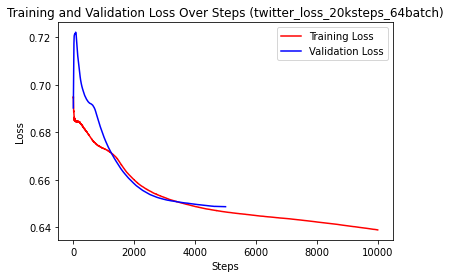

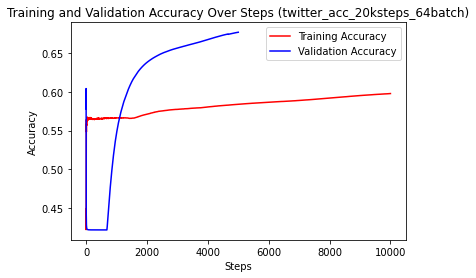

CPU times: user 1min 2s, sys: 1.46 s, total: 1min 3s
Wall time: 1min 3s


In [ ]:

set_seeds()
model = nflStatsModule(256, twitter = False)

trainer = pl.Trainer(gpus = 1, deterministic=True, progress_bar_refresh_rate=0,max_steps=10000, max_epochs=8000) #,limit_val_batches=0.125) #Limit val batches

data_path = "/content/drive/MyDrive/Deep Learning Final Project/Data/all_years.csv"
data_module = nflStatsDataModule(model.batch_size, data_path)

trainer.fit(model, data_module)

#This will come later, this is how we will trach, final accuracy and how well our net performs
trainer.test(model, datamodule=data_module)

print(model.correct_predictions)
if len(model.correct_predictions) > 45*3:
  print('DATA CORRUPTED RERUN CELL 2')
else:
  accuracy = 100 * float(sum(model.correct_predictions)) / len(model.correct_predictions)
  print(accuracy)
print(model.validation_accuracy[-1])

#Plot Data
plot_data(model.training_loss,model.validation_loss, 'Loss',save = [False, "twitter_loss_20ksteps_"+ str(i)+"batch"],show= True)
plot_data(model.training_accuracy,model.validation_accuracy, 'Accuracy',save = [False,"twitter_acc_20ksteps_"+ str(i)+"batch"],show = True)




/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: You have set progress_bar_refresh_rate < 20 on Google Colab. This may crash. Consider using progress_bar_refresh_rate >= 20 in Trainer.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.6564, device='cuda:0')}
--------------------------------------------------------------------------------
[1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]
58.59375
0.75


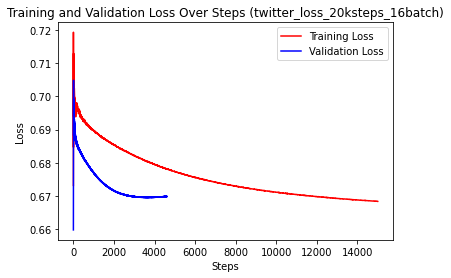

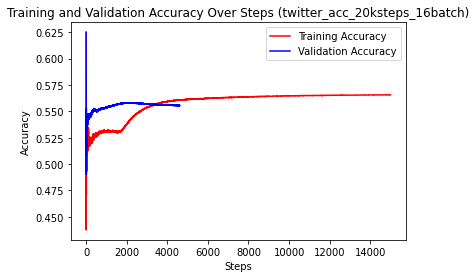

In [ ]:
set_seeds()
for i in [16]:
  model = nflStatsModule(batch_size = i,twitter = True)

  trainer = pl.Trainer(gpus = 1, max_steps=15000, deterministic=True, progress_bar_refresh_rate=0,max_epochs=15000) #,limit_val_batches=0.125) #Limit val batches

  data_path = "/content/drive/MyDrive/Deep Learning Final Project/Data/all_years_twitter.csv"
  data_module = nflStatsDataModule(model.batch_size,data_path)

  trainer.fit(model, data_module)

  #This will come later, this is how we will track, final accuracy and how well our net performs
  trainer.test(model, datamodule=data_module)

  print(model.correct_predictions)
  if len(model.correct_predictions) > 45*3:
    print('DATA CORRUPTED RERUN CELL 2')
  else:
    accuracy = 100 * float(sum(model.correct_predictions)) / len(model.correct_predictions)
    print(accuracy)
  print(model.validation_accuracy[-1])

  #Plot Data
  plot_data(model.training_loss,model.validation_loss, 'Loss', save= [False,"twitter_loss_20ksteps_"+ str(i)+"batch"], show = True)
  plot_data(model.training_accuracy,model.validation_accuracy, 'Accuracy',save= [False,"twitter_acc_20ksteps_"+ str(i)+"batch"], show = True)

In [ ]:
print(model.validation_accuracy[-10:])

[0.375, 0.75, 0.6875, 0.5, 0.625, 0.5625, 0.5, 0.4375, 0.375, 0.75]


### Multi Run Test (loops)

In [ ]:
set_seeds()

steps = [1000 + x*1000 for x in range(1,11)]
batches = [1,2,4,8,16,32,64,128,256,512]

acc = np.zeros([len(steps),len(batches)])
for b in range(len(batches)):
  for s in range(len(steps)):
    model = nflStatsModule(batches[b])

    trainer = pl.Trainer(gpus = 1, deterministic=True, progress_bar_refresh_rate=0,max_steps=steps[s],max_epochs = 2000) #,limit_val_batches=0.125) #Limit val batches

    data_path = ['/content/drive/MyDrive/Deep Learning Final Project/Data/2010_examples.csv','/content/drive/MyDrive/Deep Learning Final Project/Data/2011_examples.csv','/content/drive/MyDrive/Deep Learning Final Project/Data/2012_examples.csv']
    data_module = nflStatsDataModule(model.batch_size, data_path, array = True)

    trainer.fit(model, data_module)

    #This will come later, this is how we will trach, final accuracy and how well our net performs
    trainer.test(model, datamodule=data_module)
    accuracy = 100 * float(sum(model.correct_predictions)) / len(model.correct_predictions)
    acc[s][b] = accuracy

In [ ]:
acc

array([[55.55555556, 54.81481481, 52.59259259, 54.81481481, 54.81481481,
        49.62962963, 62.22222222, 58.51851852, 61.48148148, 60.        ],
       [60.74074074, 54.07407407, 52.59259259, 57.03703704, 61.48148148,
        58.51851852, 59.25925926, 52.59259259, 68.88888889, 52.59259259],
       [54.81481481, 54.07407407, 57.77777778, 60.74074074, 58.51851852,
        60.        , 57.03703704, 51.11111111, 57.77777778, 62.22222222],
       [52.59259259, 56.2962963 , 46.66666667, 52.59259259, 54.07407407,
        57.77777778, 58.51851852, 51.11111111, 56.2962963 , 60.        ],
       [54.07407407, 52.59259259, 58.51851852, 57.03703704, 49.62962963,
        58.51851852, 47.40740741, 54.81481481, 54.07407407, 57.03703704],
       [59.25925926, 58.51851852, 62.22222222, 57.03703704, 54.07407407,
        58.51851852, 54.81481481, 56.2962963 , 65.92592593, 60.74074074],
       [55.55555556, 54.81481481, 56.2962963 , 51.11111111, 56.2962963 ,
        57.03703704, 54.07407407, 53.33333333

In [ ]:
acc_t = [[55.55555556, 57.03703704, 59.25925926, 59.25925926, 57.03703704,
        46.66666667, 60.        , 54.81481481, 62.22222222, 54.07407407],
       [52.59259259, 58.51851852, 63.7037037 , 53.33333333, 57.03703704,
        51.11111111, 54.07407407, 63.7037037 , 51.85185185, 58.51851852],
       [54.07407407, 60.        , 52.59259259, 57.03703704, 54.07407407,
        55.55555556, 60.        , 59.25925926, 57.03703704, 61.48148148],
       [50.37037037, 57.03703704, 57.77777778, 51.11111111, 60.74074074,
        63.7037037 , 56.2962963 , 51.11111111, 68.14814815, 51.85185185],
       [54.07407407, 54.07407407, 49.62962963, 55.55555556, 46.66666667,
        45.18518519, 50.37037037, 54.07407407, 60.74074074, 62.96296296],
       [57.77777778, 54.07407407, 51.85185185, 59.25925926, 53.33333333,
        57.77777778, 65.92592593, 54.07407407, 56.2962963 , 43.7037037 ],
       [52.59259259, 54.07407407, 56.2962963 , 48.88888889, 60.        ,
        54.81481481, 57.03703704, 56.2962963 , 57.77777778, 64.44444444],
       [59.25925926, 55.55555556, 55.55555556, 68.88888889, 54.81481481,
        60.        , 54.07407407, 57.03703704, 54.81481481, 63.7037037 ],
       [53.33333333, 52.59259259, 58.51851852, 54.81481481, 53.33333333,
        61.48148148, 54.07407407, 65.18518519, 56.2962963 , 60.        ],
       [55.55555556, 58.51851852, 53.33333333, 48.88888889, 60.        ,
        62.96296296, 51.85185185, 61.48148148, 57.77777778, 57.77777778]]

        

NameError: ignored

In [ ]:
set_seeds()

steps = [1000 + x*1000 for x in range(1,11)]
batches = [1,2,4,8,16,32,64,128,256,512]

acc_t = np.zeros([len(steps),len(batches)])
for b in range(len(batches)):
  for s in range(len(steps)):
    model = nflStatsModule(batches[b],twitter = True)

    trainer = pl.Trainer(gpus = 1, deterministic=True, progress_bar_refresh_rate=0,max_steps=steps[s],max_epochs = 2000) #,limit_val_batches=0.125) #Limit val batches

    data_path = '/content/drive/MyDrive/Deep Learning Final Project/Data/all_years_twitter.csv'
    data_module = nflStatsDataModule(model.batch_size, data_path)

    trainer.fit(model, data_module)

    #This will come later, this is how we will trach, final accuracy and how well our net performs
    trainer.test(model, datamodule=data_module)
    accuracy = 100 * float(sum(model.correct_predictions)) / len(model.correct_predictions)
    acc_t[s][b] = accuracy

/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: You have set progress_bar_refresh_rate < 20 on Google Colab. This may crash. Consider using progress_bar_refresh_rate >= 20 in Trainer.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-------------

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.7950, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.6136, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.8920, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.8609, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.6104, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.7243, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.7466, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.6657, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.5957, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.8310, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.8474, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.8272, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.8478, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.6001, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.6445, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.4576, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.5645, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.7011, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.8122, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.8233, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.6228, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.8147, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.7125, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.4508, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.7725, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.6204, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.5936, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.6136, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.6920, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.6351, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.6078, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.8063, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.8479, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.6002, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.7647, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.5405, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.6558, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.7730, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.7699, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.7106, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.5112, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.6616, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.8138, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.8195, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.5355, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.8962, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.6515, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.8430, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.6084, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.4740, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.7956, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.5798, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.8144, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.4419, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.2780, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.5603, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.5539, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.5812, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.8627, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(1.1312, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.6061, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.7266, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.6135, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.7083, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.6006, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.5327, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.8203, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.6028, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.7965, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.6320, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.7454, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.3872, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.8333, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.6154, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.8111, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.7970, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.7309, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.8237, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(1.0535, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.6447, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.3704, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.5949, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.6263, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.6294, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.5939, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.6165, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.2229, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.5803, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.8206, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.5941, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.5759, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.6166, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.5760, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.8975, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.4108, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.7499, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(1.3384, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.3940, device='cuda:0')}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 64    
1 | layer_2 | Linear | 30    
2 | layer_3 | Linear | 14    
-----------------------------------
108       Trainable params
0         Non-trainable params
108       Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.7487, device='cuda:0')}
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': tensor(0.4491, device='cuda:0')}
--------------------------------------------------------------------------------


# Final Tests

In [ ]:
set_seeds()

model2 = nflStatsModule(twitter = True)

trainer = pl.Trainer(gpus = 1, max_steps=1000, deterministic=True, progress_bar_refresh_rate=0) #max_epochs=8000) #,limit_val_batches=0.125) #Limit val batches

data_path = "/content/drive/MyDrive/Deep Learning Final Project/Data/all_years_twitter.csv"
data_module = nflStatsDataModule(train_batch=29, val_batch=7, data_dir=data_path)

trainer.fit(model2, data_module)

#This will come later, this is how we will track, final accuracy and how well our net performs
trainer.test(model2, datamodule=data_module)

plt.plot(ema(model2.training_loss), 'r', label = "Training Loss")
plt.plot(ema(model2.validation_loss), 'b', label = "Validation Loss")
plt.title('Loss over steps')
plt.ylabel('Loss')
plt.xlabel('Steps')
plt.legend()
plt.show()

plt.plot(ema(model2.training_accuracy), 'r', label = "Training Accuracy")
plt.plot(ema(model2.validation_accuracy), 'b', label = "Validation Accuracy")
plt.title('Accuracy over steps')
plt.ylabel('Accuracy')
plt.xlabel('Steps')
plt.legend()
plt.show()

print(model2.validation_accuracy[-1])

In [ ]:
set_seeds()

model = nflStatsModule()

trainer = pl.Trainer(gpus = 1, max_steps=9000, deterministic=True, progress_bar_refresh_rate=0) #max_epochs=8000) #,limit_val_batches=0.125) #Limit val batches

data_path = "/content/drive/MyDrive/Deep Learning Final Project/Data/all_years.csv"
data_module = nflStatsDataModule(train_batch=29, val_batch=7, data_dir=data_path)

trainer.fit(model, data_module)

#This will come later, this is how we will track, final accuracy and how well our net performs
trainer.test(model, datamodule=data_module)

plt.plot(ema(model.training_loss), 'r', label = "Training Loss")
plt.plot(ema(model.validation_loss), 'b', label = "Validation Loss")
plt.title('Loss over steps')
plt.ylabel('Loss')
plt.xlabel('Steps')
plt.legend()
plt.show()

plt.plot(ema(model.training_accuracy), 'r', label = "Training Accuracy")
plt.plot(ema(model.validation_accuracy), 'b', label = "Validation Accuracy")
plt.title('Accuracy over steps')
plt.ylabel('Accuracy')
plt.xlabel('Steps')
plt.legend()
plt.show()

print(model.validation_accuracy[-1])
# #Plot Data

# plot_data(model2.training_loss, model2.validation_loss, 'Loss', save= [True,"twitter_loss_1ksteps"], show = True)
# plot_data(model2.training_accuracy,model2.validation_accuracy, 'Accuracy',save= [True,"twitter_acc_1ksteps"], show = True)

In [ ]:
print(model.correct_predictions)
accuracy = 100 * float(sum(model.correct_predictions)) / len(model.correct_predictions)
print(accuracy)